In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random

In [7]:
def get_dihedrals_all_replicas(i, aa, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)

    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}ns.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}ns_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    n_iter = 5000
    
    from tqdm import tqdm
    dihedrals_master = []
    all_pos_hybrid_master = []
    for j in [0]:
        index = j # of replica
#         all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
        all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
        all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
        for iteration in tqdm(range(3000,  4000)):
            replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
            pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
#             all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
            all_pos_hybrid[iteration] = pos # Get hybrid positions
            all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)
        all_pos_hybrid_master.append(all_pos_hybrid)
        
        dihedrals_all = []
        # write for loop for this part -- old and new atoms
#         for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
#             traj = md.Trajectory(np.array(pos), top)
#     #         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices])))
#             dihedrals = md.compute_dihedrals(traj, np.array([indices]))
#             dihedrals_all.append(dihedrals)
        traj = md.Trajectory(np.array(all_pos_old), old_top)
        dihedrals = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
        dihedrals_all.append(dihedrals)
        dihedrals_master.append(dihedrals_all)
    return dihedrals_master, n_iter, all_pos_hybrid_master

def plot_dihedrals(dihedrals, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
#     plt.savefig(outfile, dpi=300)
    plt.close()

def plot_time_series(dihedrals, n_iter, outfile):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("dihedral")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
    plt.show()
#     plt.savefig(outfile, dpi=300)
    plt.close()

    return uncorrelated_indices

def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.savefig(outfile, dpi=300)
    plt.close()



In [8]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/12/36/"
name = "THR"
endstate = 0
phase = "apo"
length = 5
i = os.path.basename(os.path.dirname(outdir))
aa = name.lower()

In [4]:
with open(os.path.join(outdir, f"{i}_{phase}_{endstate}.pickle"), 'rb') as f:
    htf = pickle.load(f)

if name == 'THR': # r-htf
    indices_old = [669, 670, 673, 674]
    indices_new = [669, 670, 673, 676]
elif name == 'SER': # r-htf
    indices_old = [11, 10, 7, 6]
    indices_new = [15, 10, 7, 6]
elif name == 'ALA': # r-htf
    indices_old = [669, 670, 673, 674]
    #indices_new = [0, 6, 7, 10] # phi angle
    indices_new = [669, 670, 673, 676]
    

In [5]:
dihedrals, n_iter, all_pos_hybrid = get_dihedrals_all_replicas(i, aa, length, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 1000/1000 [18:24<00:00,  1.10s/it]


0it [00:00, ?it/s]INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (Deja

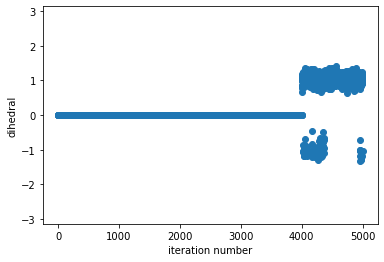

1it [00:07,  7.34s/it]


In [6]:
new_aa = "ala"
old_aa = "thr"

for j, replica in tqdm(enumerate(dihedrals)):
#     dihedrals_new = replica[0]
#     dihedrals_old = replica[1]
    dihedrals_old = replica[0]
    plot_dihedrals(dihedrals_old, os.path.join(outdir, f"{i}_{phase}_{aa}_{length}_{j}_{old_aa}_correlated.png"))
    uncorrelated_old = plot_time_series(dihedrals_old, n_iter, os.path.join(outdir, f"{i}_{phase}_{aa}_{length}_{j}_{old_aa}_timeseries.png"))
#     plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old, os.path.join(out_dir, f"{i}_{args.phase}_{aa}_{length}_{j}_{old_aa}_decorrelated.png"))
#     plot_dihedrals(dihedrals_new, os.path.join(out_dir, f"{i}_{args.phase}_{aa}_{length}_{j}_{new_aa}_correlated.png"))
#     uncorrelated_new = plot_time_series(dihedrals_new, n_iter, os.path.join(out_dir, f"{i}_{args.phase}_{aa}_{length}_{j}_{new_aa}_timeseries.png"))
#     plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new, os.path.join(out_dir, f"{i}_{args.phase}_{aa}_{length}_{j}_{new_aa}_decorrelated.png"))

In [36]:
# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 298.0 * unit.kelvin  # Minimum temperature.
T_max = 1200.0 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

In [11]:
temperatures

[Quantity(value=298.0, unit=kelvin),
 Quantity(value=347.95853028599566, unit=kelvin),
 Quantity(value=402.6715859162709, unit=kelvin),
 Quantity(value=462.5916524047109, unit=kelvin),
 Quantity(value=528.2142780581083, unit=kelvin),
 Quantity(value=600.0821722380443, unit=kelvin),
 Quantity(value=678.7896936520565, unit=kelvin),
 Quantity(value=764.9877657929634, unit=kelvin),
 Quantity(value=859.3892601777964, unit=kelvin),
 Quantity(value=962.7748919065651, unit=kelvin),
 Quantity(value=1075.999676298049, unit=kelvin),
 Quantity(value=1200.0, unit=kelvin)]

In [16]:
# Create states for each replica
n_replicas = 20  # Number of temperature replicas.
T_min = 298.0 * unit.kelvin  # Minimum temperature.
T_max = 2000.0 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

In [17]:
temperatures

[Quantity(value=298.0, unit=kelvin),
 Quantity(value=351.5291669665935, unit=kelvin),
 Quantity(value=407.95111663096566, unit=kelvin),
 Quantity(value=467.42217856465265, unit=kelvin),
 Quantity(value=530.1071305834903, unit=kelvin),
 Quantity(value=596.1796553012331, unit=kelvin),
 Quantity(value=665.8228213559005, unit=kelvin),
 Quantity(value=739.2295906421895, unit=kelvin),
 Quantity(value=816.603352955359, unit=kelvin),
 Quantity(value=898.1584895279351, unit=kelvin),
 Quantity(value=984.1209670206374, unit=kelvin),
 Quantity(value=1074.7289636133153, unit=kelvin),
 Quantity(value=1170.233528930615, unit=kelvin),
 Quantity(value=1270.8992796308519, unit=kelvin),
 Quantity(value=1377.0051325853656, unit=kelvin),
 Quantity(value=1488.845077679805, unit=kelvin),
 Quantity(value=1606.7289923785465, unit=kelvin),
 Quantity(value=1730.983500309194, unit=kelvin),
 Quantity(value=1861.952876246047, unit=kelvin),
 Quantity(value=2000.0, unit=kelvin)]

In [29]:
# Create states for each replica
n_replicas = 40  # Number of temperature replicas.
T_min = 298.0 * unit.kelvin  # Minimum temperature.
T_max = 5000.0 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

In [30]:
temperatures

[Quantity(value=298.0, unit=kelvin),
 Quantity(value=369.07279512770856, unit=kelvin),
 Quantity(value=441.99153443322905, unit=kelvin),
 Quantity(value=516.8041618577208, unit=kelvin),
 Quantity(value=593.5598665704056, unit=kelvin),
 Quantity(value=672.3091153103605, unit=kelvin),
 Quantity(value=753.1036855683083, unit=kelvin),
 Quantity(value=835.9966996302245, unit=kelvin),
 Quantity(value=921.0426595051475, unit=kelvin),
 Quantity(value=1008.2974827601512, unit=kelvin),
 Quantity(value=1097.8185392860446, unit=kelvin),
 Quantity(value=1189.6646890179768, unit=kelvin),
 Quantity(value=1283.8963206357334, unit=kelvin),
 Quantity(value=1380.5753912691916, unit=kelvin),
 Quantity(value=1479.7654672350202, unit=kelvin),
 Quantity(value=1581.5317658314184, unit=kelvin),
 Quantity(value=1685.9411982183744, unit=kelvin),
 Quantity(value=1793.0624134116365, unit=kelvin),
 Quantity(value=1902.9658434193132, unit=kelvin),
 Quantity(value=2015.7237495507952, unit=kelvin),
 Quantity(value=213